In [26]:
# Import libraries

import pandas as pd
import numpy as np
import sklearn as skl
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.metrics import root_mean_squared_error, r2_score
from scipy.stats import chi2_contingency
import warnings

warnings.filterwarnings('ignore')

pd.options.display.float_format = '{:,.3f}'.format

In [27]:
# Import data
dfMedicare_raw = pd.read_csv("https://breathecode.herokuapp.com/asset/internal-link?id=416&path=medical_insurance_cost.csv")
dfMedicare_raw

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,"16,884.924"
1,18,male,33.770,1,no,southeast,"1,725.552"
2,28,male,33.000,3,no,southeast,"4,449.462"
3,33,male,22.705,0,no,northwest,"21,984.471"
4,32,male,28.880,0,no,northwest,"3,866.855"
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,"10,600.548"
1334,18,female,31.920,0,no,northeast,"2,205.981"
1335,18,female,36.850,0,no,southeast,"1,629.833"
1336,21,female,25.800,0,no,southwest,"2,007.945"


In [28]:
# Data inspection

print(dfMedicare_raw.shape)
print(dfMedicare_raw.info())

# Verify duplicates and NANs

if dfMedicare_raw.duplicated().any().any():
    dfMedicare_raw = dfMedicare_raw.drop_duplicates()

if dfMedicare_raw.isna().any().any():
    dfinsurance_raw = dfMedicare_raw.dropna()

(1338, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB
None


In [29]:
# Generate processed dataframe

dfMedicare_processed = dfMedicare_raw.select_dtypes(include=['float64', 'int64']) # Extract only numerical data

# Encoding sex

unique_sex   = dfMedicare_raw['sex'].unique() # Get list of unique jobs
sex_encoding = np.array([0,1]) # Generate list to encode
sex_dict     = dict(zip(unique_sex, sex_encoding))

dfMedicare_processed.insert(loc=1,column="sex_encoded",value=dfMedicare_raw['sex'].map(sex_dict))

# Encoding smoker

unique_smoker  = dfMedicare_raw['smoker'].unique() # Get list of unique jobs
smoker_encoding = np.array([1,0]) # Generate list to encode
smoker_dict     = dict(zip(unique_smoker,smoker_encoding))

dfMedicare_processed.insert(loc=4,column="smoker_encoded",value=dfMedicare_raw['smoker'].map(smoker_dict))

# Encoding region

unique_region  = dfMedicare_raw['region'].unique() # Get list of unique region statuses
region_encoding = np.array([0,1,2,3]) # Generate list to encode
region_dict     = dict(zip(unique_region,region_encoding))

dfMedicare_processed.insert(loc=5,column="region_encoded",value=dfMedicare_raw['region'].map(region_dict))

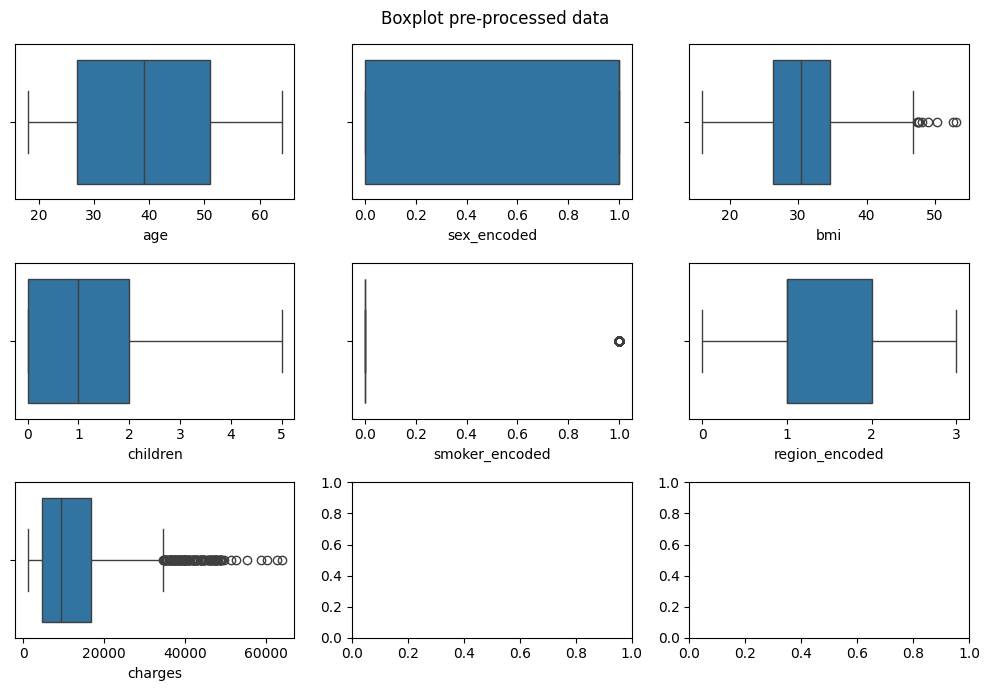

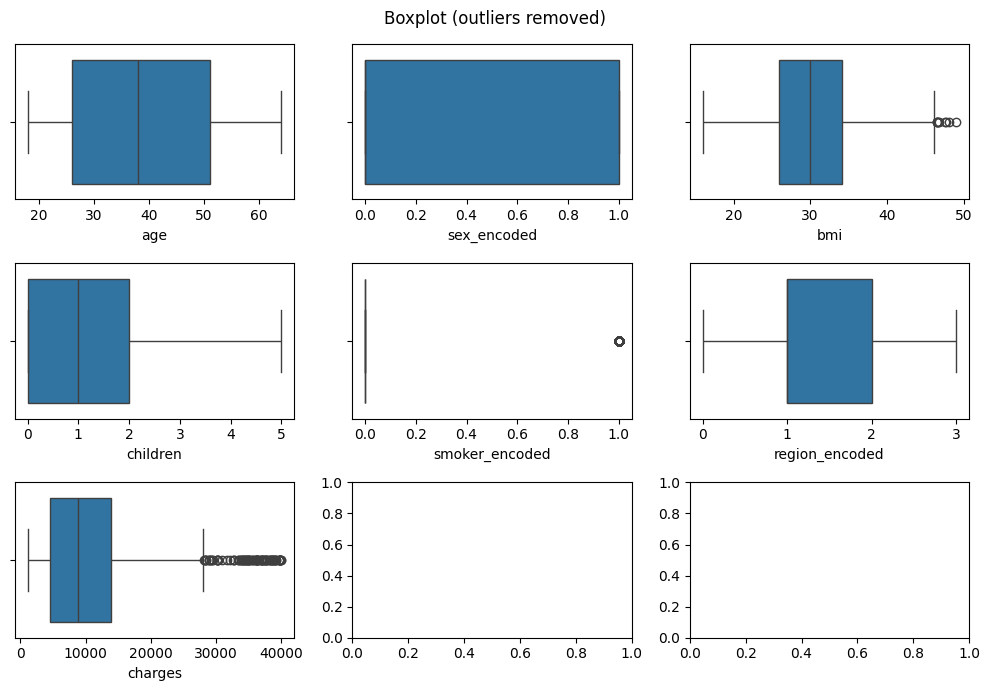

In [30]:
# Exploratory data analysis

# Get outliers
fig, axis = plt.subplots(3,3,figsize=(10,7))
r = 0
c = 0
for dfcol in dfMedicare_processed.columns:
    sn.boxplot(ax=axis[r,c], data = dfMedicare_processed, x = dfcol)
    c += 1
    if c > 2:
        r += 1
        c = 0

plt.suptitle('Boxplot pre-processed data')
plt.tight_layout()

# Remove some of the outliers

dfMedicare_processed = dfMedicare_processed[dfMedicare_processed['bmi'] <= 50]
dfMedicare_processed = dfMedicare_processed[dfMedicare_processed['charges'] <= 40000]

fig, axis = plt.subplots(3,3,figsize=(10,7))
r = 0
c = 0
for dfcol in dfMedicare_processed.columns:
    sn.boxplot(ax=axis[r,c], data = dfMedicare_processed, x = dfcol)
    c += 1
    if c > 2:
        r += 1
        c = 0

plt.suptitle('Boxplot (outliers removed)')
plt.tight_layout()        

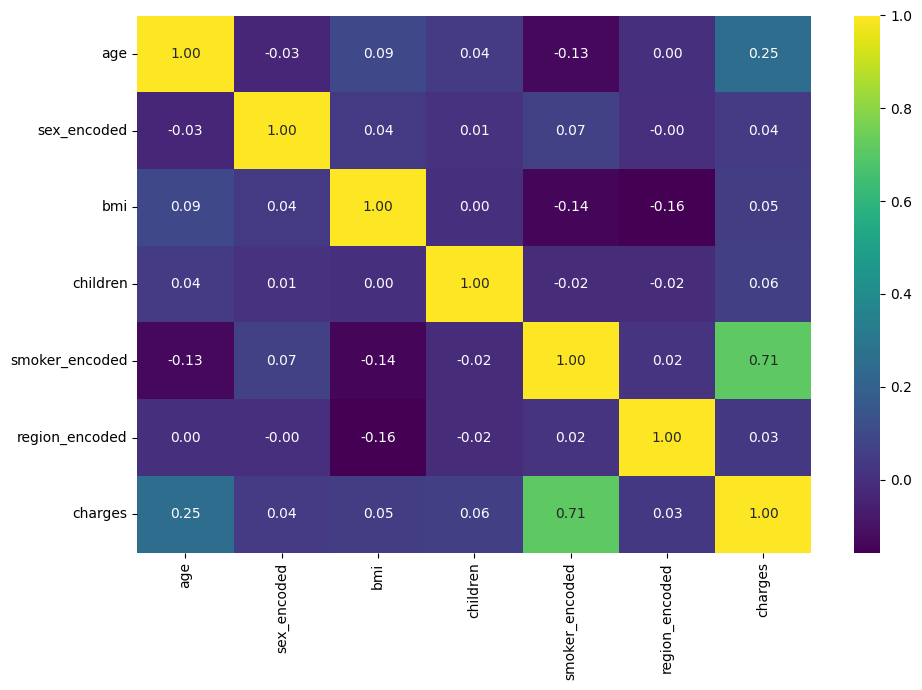

'\nAge and smoker are inversely correlated, indicating that the older the person is the more likely they are to smoke.\nHowever, the correlation is rather weak, with a linear coefficient of only 0.13 \n'

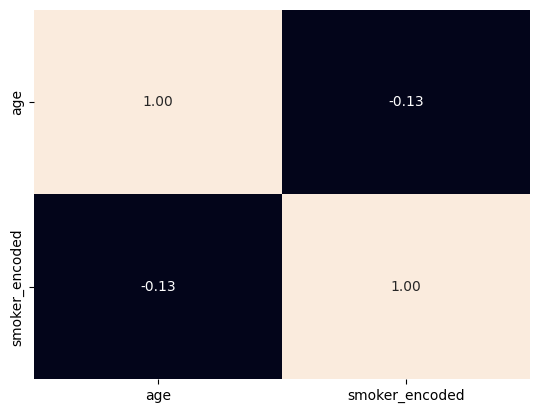

In [31]:
# Get correlation matrix

fig, ax = plt.subplots(figsize=(10,7))
sn.heatmap(dfMedicare_processed.corr(method="pearson"), annot=True, fmt=".2f", cmap="viridis", ax=ax)
plt.tight_layout()
plt.show()

"""
Age and smoker category are the variables that are the more strongly correlated with the charge rate
"""

# Verification that age and smoker are not strongly correlated

plt.figure
sn.heatmap(dfMedicare_processed[["age", "smoker_encoded"]].corr(), annot = True, fmt = ".2f", cbar = False)

"""
Age and smoker are inversely correlated, indicating that the older the person is the more likely they are to smoke.
However, the correlation is rather weak, with a linear coefficient of only 0.13 
"""

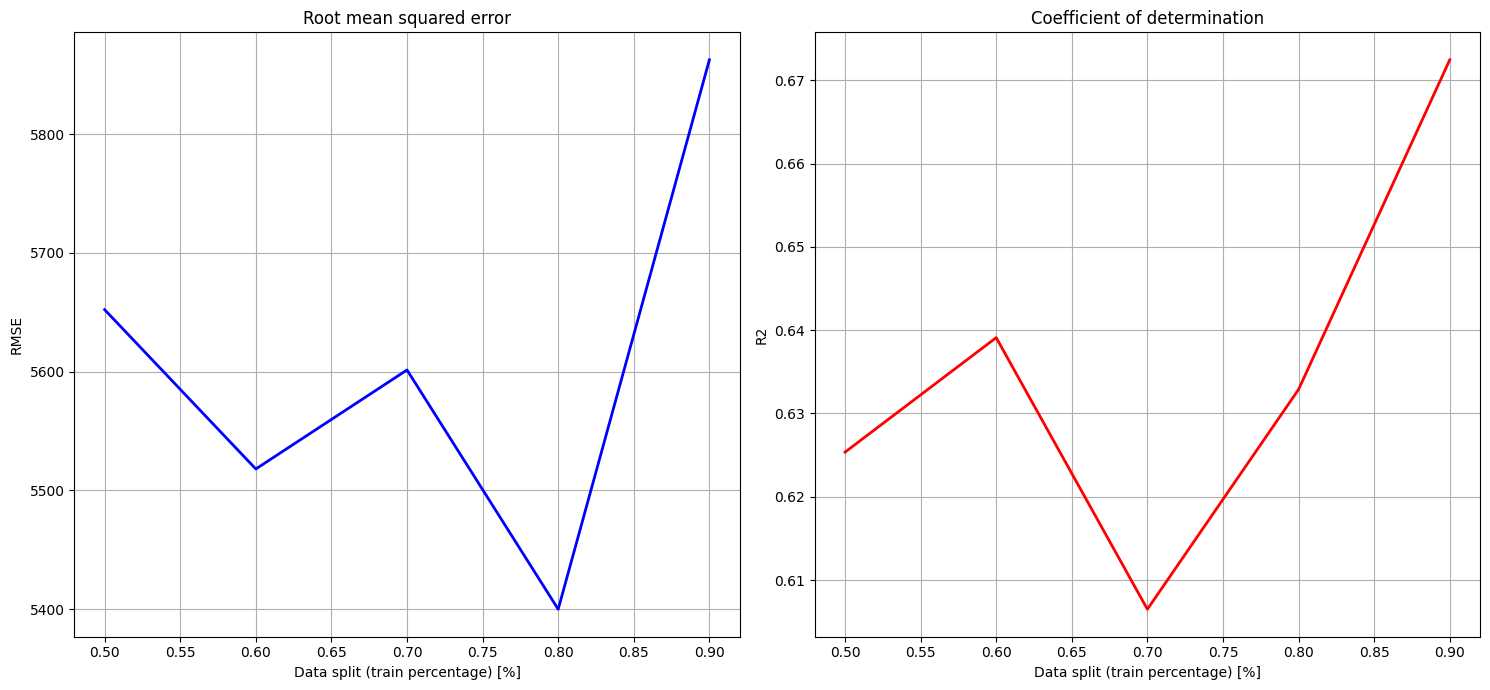

In [32]:
# # Exclusion of independent variables based on the correlation matrix

features = ['age','smoker_encoded']
target   = 'charges'

# Set up the data

X = dfMedicare_processed[features]
y = dfMedicare_processed[target]

# To test best split trade-off we loop over different splitting ratios

rmse = []
r2   = []


for split_ratio in np.arange(0.5,1,0.1):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, train_size = split_ratio)

    # Logistic regression

    insurance_model = LinearRegression()
    insurance_model.fit(X_train, y_train)

    # Perform prediction
    y_pred = insurance_model.predict(X_test)

    # Compute accuracy, precision, and recall
    rmse.append(root_mean_squared_error(y_test, y_pred))
    r2.append(r2_score(y_test, y_pred))

# Plot split vs. scores

fig, (ax0,ax1) = plt.subplots(1,2,figsize=(15,7))

ax0.plot(np.arange(0.5,1,0.1),rmse,color='blue',linewidth=2)
ax0.grid()
ax0.set_xlabel("Data split (train percentage) [%]")
ax0.set_ylabel("RMSE")
ax0.set_title("Root mean squared error")
ax1.plot(np.arange(0.5,1,0.1),r2,color='red',linewidth=2)
ax1.grid()
ax1.set_xlabel("Data split (train percentage) [%]")
ax1.set_ylabel("R2")
ax1.set_title("Coefficient of determination")

plt.tight_layout()